# Process Scheduling Simulator

In [1]:
from collections import deque
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import subprocess


### Calculating waiting time and turnaround time

In [120]:
def TAT_WT(process):
    for p in process:
        p['TAT'] = p['CT'] - p['AT']
        p['WT'] = p['TAT'] - p['BT']
    return process

### FCFS scheduling

In [123]:
def FCFS(process):
    process = sorted(copy.deepcopy(process), key=lambda x: x['AT'])
    time = 0
    gantt = []

    for p in process:
        if time < p['AT']:
            time = p['AT']
        start = time
        time += p['BT']
        p['CT'] = time
        gantt.append((p['Pid'], start, time))

    return TAT_WT(process), gantt

### SJF scheduling

In [126]:
def SJF(process):
    process = copy.deepcopy(process)
    completed = []
    time = 0
    gantt = []

    while process:
        available = [p for p in process if p['AT'] <= time]

        if not available:
            time = min(process, key=lambda p: p['AT'])['AT']
            continue

        current = min(available, key=lambda p: p['BT'])
        start = time
        time += current['BT']
        current['CT'] = time
        gantt.append((current['Pid'], start, time))

        completed.append(current)
        process.remove(current)

    return TAT_WT(completed), gantt

### Priority scheduling

In [2]:
def PriorityScheduling(process):
    process = copy.deepcopy(process)
    completed = []
    time = 0
    gantt = []

    while process:
        available = [p for p in process if p['AT'] <= time]

        if not available:
            time = min(process, key=lambda p: p['AT'])['AT']
            continue

        current = min(available, key=lambda p: p['Priority'])
        start = time
        time += current['BT']
        current['CT'] = time
        gantt.append((current['Pid'], start, time))

        completed.append(current)
        process.remove(current)

    return TAT_WT(completed), gantt

In [3]:
def get_linux_snapshot(limit=5):
    """
    Use `ps` to grab a snapshot of real Linux processes and
    convert them into our scheduling table format.

    Returns a list like:
      [
        {'Pid': '1234', 'AT': 0, 'BT': 120, 'priority': 0, 'name': 'python'},
        ...
      ]
    """
    # pid   : process ID
    # ni    : nice value (we'll treat as 'priority')
    # comm  : command name
    # etimes: elapsed time in seconds (we'll use as fake burst time)
    cmd = ["ps", "-eo", "pid,ni,comm,etimes", "--sort=-%cpu"]

    result = subprocess.run(cmd, capture_output=True, text=True, check=True)
    lines = result.stdout.strip().splitlines()

    if len(lines) <= 1:
        return []

    header = lines[0]      # we don't really need it, but it's there
    data_lines = lines[1:]

    table = []
    for line in data_lines[:limit]:
        parts = line.split(None, 3)  # split into at most 4 chunks
        if len(parts) < 4:
            continue

        pid_str, nice_str, comm, etimes_str = parts

        try:
            pid = int(pid_str)
            nice = int(nice_str)
            etimes = int(etimes_str)
        except ValueError:
            continue

        row = {
            "Pid": str(pid),          # keep it string, matches your existing tables
            "AT": 0,                  # assume they have all 'arrived'
            "BT": max(etimes, 1),     # fake CPU burst using elapsed time
            "priority": nice,         # Linux nice value as our priority
            "name": comm,             # process name (optional but nice to have)
        }
        table.append(row)

    return table


### Round Robin scheduling

In [4]:
def RoundRobin(process, quantum):
    process = copy.deepcopy(process)
    queue = deque(sorted(process, key=lambda x: x['AT']))
    time = 0
    gantt = []

    for p in queue:
        p['remaining'] = p['BT']

    completed = []
    ready = deque()

    while queue or ready:
        while queue and queue[0]['AT'] <= time:
            ready.append(queue.popleft())

        if not ready:
            time = queue[0]['AT']
            continue

        p = ready.popleft()
        start = time
        exec_time = min(quantum, p['remaining'])
        time += exec_time
        p['remaining'] -= exec_time
        gantt.append((p['Pid'], start, time))

        while queue and queue[0]['AT'] <= time:
            ready.append(queue.popleft())

        if p['remaining'] > 0:
            ready.append(p)
        else:
            p['CT'] = time
            completed.append(p)

    return TAT_WT(completed), gantt

In [6]:
import subprocess
import platform
import sys

def get_linux_snapshot(limit=5):
    try:
        # Check if we're on Linux
        if platform.system() != "Linux":
            print(f"This function only works on Linux, but you're using {platform.system()}")
            return []
            
        # Try to execute the ps command
        output = subprocess.check_output(['ps', '-eo', 'pid,ni,comm,etimes', '--sort=-%cpu'], 
                                        universal_newlines=True)
        
        # Process the output
        lines = output.strip().split('\n')
        header = lines[0]
        processes = lines[1:limit+1]
        
        # Convert to table format
        result = []
        for p in processes:
            fields = p.split()
            if len(fields) >= 4:
                result.append({
                    'PID': fields[0],
                    'NI': fields[1],
                    'COMMAND': fields[2],
                    'TIME': fields[3]
                })
        return result
        
    except subprocess.CalledProcessError as e:
        print(f"Error executing command: {e}")
        return []
    except Exception as e:
        print(f"Unexpected error: {e}")
        return []

# Get the snapshot
linux_table = get_linux_snapshot(limit=5)

# Print results
print("Linux snapshot (converted to our table format):")
if linux_table:
    for p in linux_table:
        print(p)
else:
    print("No process information available.")


This function only works on Linux, but you're using Windows
Linux snapshot (converted to our table format):
No process information available.


## Test case

In [135]:
Table = [
    {'Pid': 'P1', 'AT': 0, 'BT': 6, 'Priority': 3},
    {'Pid': 'P2', 'AT': 2, 'BT': 4, 'Priority': 1},
    {'Pid': 'P3', 'AT': 4, 'BT': 5, 'Priority': 4},
    {'Pid': 'P4', 'AT': 6, 'BT': 3, 'Priority': 2},
]

In [137]:
def print_results_table(results, title):
    print(f"\n{title}")
    print("{:<5} {:<5} {:<5} {:<5} {:<5} {:<5}".format(
        'Pid', 'AT', 'BT', 'CT', 'TAT', 'WT'
    ))
    
    total_tat = 0
    total_wt = 0
    
    for r in results:
        print("{:<5} {:<5} {:<5} {:<5} {:<5} {:<5}".format(
            r['Pid'], r['AT'], r['BT'], r['CT'], r['TAT'], r['WT']
        ))
        total_tat += r['TAT']
        total_wt += r['WT']
    
    n = len(results)
    print("\nAverage TAT =", round(total_tat / n, 2))
    print("Average WT  =", round(total_wt / n, 2))

In [139]:
fcfs_res, _ = FCFS(Table)
sjf_res, _ = SJF(Table)
rr_res, _  = RoundRobin(Table, quantum=2)
prio_res, _ = PriorityScheduling(Table)

print_results_table(fcfs_res, "FCFS Scheduling")
print_results_table(sjf_res, "SJF Scheduling")
print_results_table(rr_res, "Round Robin (q=2)")
print_results_table(prio_res, "Priority Scheduling")



FCFS Scheduling
Pid   AT    BT    CT    TAT   WT   
P1    0     6     6     6     0    
P2    2     4     10    8     4    
P3    4     5     15    11    6    
P4    6     3     18    12    9    

Average TAT = 9.25
Average WT  = 4.75

SJF Scheduling
Pid   AT    BT    CT    TAT   WT   
P1    0     6     6     6     0    
P4    6     3     9     3     0    
P2    2     4     13    11    7    
P3    4     5     18    14    9    

Average TAT = 8.5
Average WT  = 4.0

Round Robin (q=2)
Pid   AT    BT    CT    TAT   WT   
P2    2     4     10    8     4    
P1    0     6     14    14    8    
P4    6     3     17    11    8    
P3    4     5     18    14    9    

Average TAT = 11.75
Average WT  = 7.25

Priority Scheduling
Pid   AT    BT    CT    TAT   WT   
P1    0     6     6     6     0    
P2    2     4     10    8     4    
P4    6     3     13    7     4    
P3    4     5     18    14    9    

Average TAT = 8.75
Average WT  = 4.25


### Plotting the Gantt charts

In [142]:
def Gantt_Chart(gantt_data, title="Gantt Chart"):
    
    fig, ax = plt.subplots(figsize=(10, 2.8))

    process = list({pid for pid, _, _ in gantt_data})
    colors = {pid: cm.tab10(i % 10) for i, pid in enumerate(process)}
    y = 0  
    for pid, start, end in gantt_data:
        ax.barh(
            y, end - start, left=start, height=0.45,
            edgecolor='black', color=colors[pid]
        )
        ax.text(
            (start + end) / 2, y, pid,
            va='center', ha='center', fontsize=10, color='white'
        )

    ax.set_yticks([])
    ax.set_xlabel("Time")
    ax.set_title(title)
    ax.set_xlim(0, max(e for _, _, e in gantt_data) + 1)
    ax.set_xticks(range(0, int(max(e for _, _, e in gantt_data)) + 2))

    plt.tight_layout()
    plt.show()

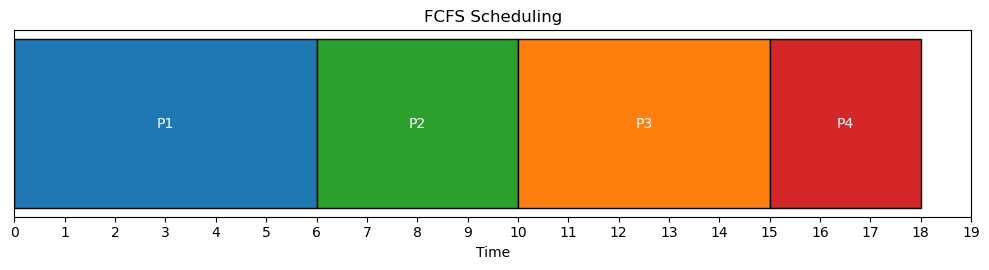

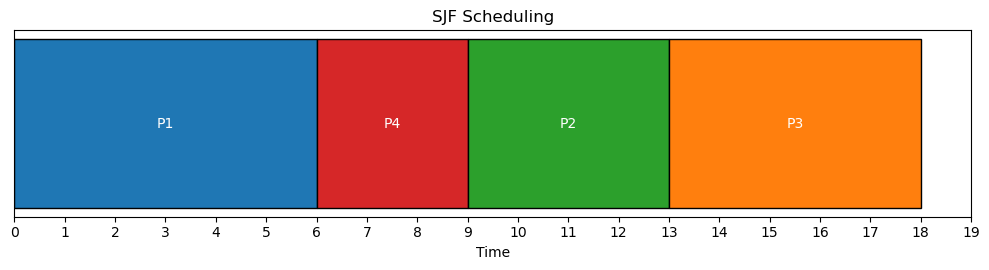

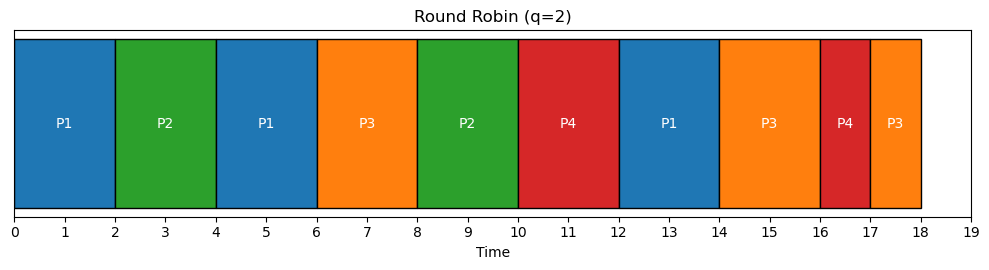

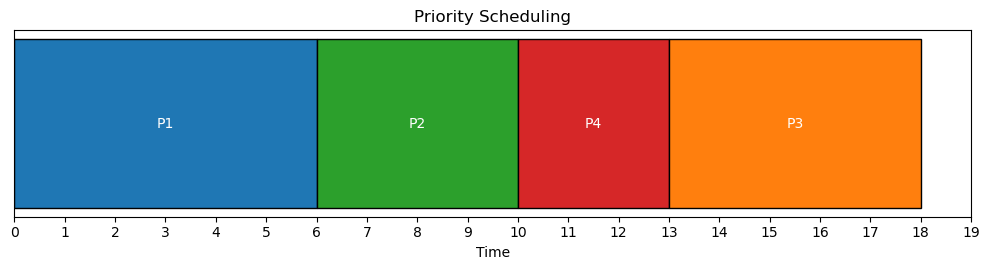

In [144]:
fcfs_res, fcfs_gantt = FCFS(Table)
sjf_res, sjf_gantt = SJF(Table)
rr_res, rr_gantt  = RoundRobin(Table, quantum=2)
prio_res, prio_gantt = PriorityScheduling(Table)

Gantt_Chart(fcfs_gantt, "FCFS Scheduling")
Gantt_Chart(sjf_gantt, "SJF Scheduling")
Gantt_Chart(rr_gantt, "Round Robin (q=2)")
Gantt_Chart(prio_gantt, "Priority Scheduling")